torch.Size([375, 500, 3])


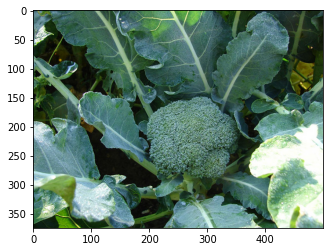

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import math

from data.visual_genome import VisualGenomeDataset
from torch.utils.data import DataLoader

from encoders import conv, vae, cnn

# filter the annoying warnings
import warnings
warnings.filterwarnings("ignore")

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# data = datasets.ImageFolder('./data/images/', transform=transform)
data = VisualGenomeDataset('./data/images/1')
dataloader = DataLoader(data, batch_size=1, shuffle=True, num_workers=1)

img = next(iter(dataloader))[0] # returns a list, so we fetch the tensor holding the batch of images
print(img.shape) # sanity check to ensure we indexed correctly
plt.imshow(  img  )

In [2]:
def train(model, train_loader, checkpoint_path='./autoencoder-continued.cpt', num_epochs=5, learning_rate=1e-3, restore=False):
    criterion = nn.MSELoss().cuda() # mean square error loss
    device = torch.device('cuda:0')
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    loss = None
    if restore:
        model.load(checkpoint_path, optimizer)

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch: ', epoch)
        i = 0
        for img in train_loader:
            img = img.cuda()
            optimizer.zero_grad()
            recon = model(img)
            loss = criterion(recon, img)
            del recon, img
            loss.backward()
            i += 1
            if i % 10 == 0:
                try:
                    print('Epoch:{}, Batch:{}, loss:{:.4f}'.format(epoch, i, loss.item()))
                except UnboundLocalError:
                    pass
            del loss
            optimizer.step()
            torch.cuda.empty_cache()
    return model


In [42]:
model = cnn.AutoEncoder(3, latent_channels=3)

# checkpoint = torch.load('./cnn-3.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

crops = [(320, 360), (400,280), (320,320), (440,360), (280,320), (400,400), (480,200)]
for crop in crops:
#     print('running with crop:', crop)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(crop),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
    ])

    data = VisualGenomeDataset('./data/images/1', transform=transform)
    dataloader = DataLoader(data, batch_size=200, shuffle=True, num_workers=3)
#     print('img: ', data[0].shape)
#     print('rec:', model(data[0].unsqueeze(0)).shape)
#     print('')

    model = train(model, dataloader, num_epochs=1, learning_rate=1e-3)

Epoch:  0
Epoch:0, Batch:10, loss:0.1825
Epoch:0, Batch:20, loss:0.1781
Epoch:0, Batch:30, loss:0.1594
Epoch:0, Batch:40, loss:0.1560
Epoch:0, Batch:50, loss:0.1411
Epoch:0, Batch:60, loss:0.1265
Epoch:0, Batch:70, loss:0.1213
Epoch:0, Batch:80, loss:0.1161
Epoch:0, Batch:90, loss:0.1119
Epoch:0, Batch:100, loss:0.1138
Epoch:0, Batch:110, loss:0.1135
Epoch:0, Batch:120, loss:0.1147
Epoch:0, Batch:130, loss:0.1049
Epoch:0, Batch:140, loss:0.1048
Epoch:0, Batch:150, loss:0.1045
Epoch:0, Batch:160, loss:0.1045
Epoch:0, Batch:170, loss:0.1114
Epoch:0, Batch:180, loss:0.1083
Epoch:0, Batch:190, loss:0.1130
Epoch:0, Batch:200, loss:0.1068
Epoch:0, Batch:210, loss:0.1083
Epoch:  0
Epoch:0, Batch:10, loss:0.1070
Epoch:0, Batch:20, loss:0.1066
Epoch:0, Batch:30, loss:0.1049
Epoch:0, Batch:40, loss:0.1058
Epoch:0, Batch:50, loss:0.1004
Epoch:0, Batch:60, loss:0.1039
Epoch:0, Batch:70, loss:0.1048
Epoch:0, Batch:80, loss:0.1001
Epoch:0, Batch:90, loss:0.1054
Epoch:0, Batch:100, loss:0.1061
Epoch:

In [43]:
state = {
            'model_state_dict': model.state_dict(),
            'loss': 0.0056,
            'epoch': 2,
        }
torch.save(state, './cnn.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 65, 87])
torch.Size([520, 696, 3])


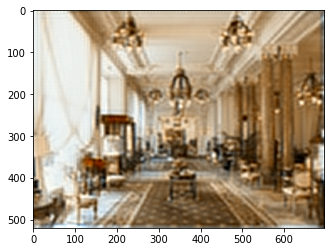

In [46]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

model.eval()
model.to(torch.device('cpu'))

# checkpoint = torch.load('./cnn-3.pt')
# m = cnn.AutoEncoder(3, latent_channels=3)
# m.load_state_dict(checkpoint['model_state_dict'])
# m.eval()
# data = VisualGenomeDataset('./data/images/1')
data = VisualGenomeDataset('./data/images/1', transform=transform)
i = data[1]
# print(i.shape)
z = i.unsqueeze(0)
for layer in model.encoder:
    z = layer(z)

print(z.shape)
# recon = model(torch.from_numpy(i).permute(2,0,1).unsqueeze(0).float())
recon = model(i.permute(0,1,2).unsqueeze(0).float())
recon = recon.detach()[0].permute(1,2,0)
print(recon.shape)
plt.imshow(recon)